<a href="https://colab.research.google.com/github/Tanha1627/AI-job-portal/blob/main/skindieases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print("Downloading HAM10000 via KaggleHub...")
dataset_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Dataset downloaded to:", dataset_path)


Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Dataset downloaded to: /kaggle/input/skin-cancer-mnist-ham10000


In [3]:
image_dir_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(dataset_path, "HAM10000_images_part_2")
csv_file = os.path.join(dataset_path, "HAM10000_metadata.csv")


# =======================
# 2️⃣ LOAD METADATA
# =======================

df = pd.read_csv(csv_file)

# Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['dx'])

print("Classes found:", le.classes_)


# =======================
# 3️⃣ TRAIN / VAL / TEST SPLIT
# =======================

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label_enc'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_enc'], random_state=42)



Classes found: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [4]:
# =======================
# 4️⃣ PREPROCESSING FUNCTIONS
# =======================

# CLAHE (illumination correction)
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# Gray-World color constancy
def gray_world(img):
    img = img.astype(np.float32)
    R, G, B = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
    avg_gray = (R + G + B) / 3

    img[:,:,0] = np.clip(img[:,:,0] * (avg_gray / R), 0, 255)
    img[:,:,1] = np.clip(img[:,:,1] * (avg_gray / G), 0, 255)
    img[:,:,2] = np.clip(img[:,:,2] * (avg_gray / B), 0, 255)

    return img.astype(np.uint8)


# =======================
# 5️⃣ LOAD IMAGES FROM BOTH FOLDERS
# =======================

IMG_SIZE = 224

# Search in both part_1 and part_2 folders
def load_image_from_dirs(image_id):
    filename = image_id + ".jpg"

    p1 = os.path.join(image_dir_1, filename)
    if os.path.exists(p1):
        return cv2.imread(p1)

    p2 = os.path.join(image_dir_2, filename)
    if os.path.exists(p2):
        return cv2.imread(p2)

    return None  # not found


def load_images(df_subset):
    images, labels = [], []
    for idx, row in df_subset.iterrows():

        img = load_image_from_dirs(row['image_id'])
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # apply preprocessing
        img = apply_clahe(img)
        img = gray_world(img)

        images.append(img)
        labels.append(row['label_enc'])

    return np.array(images), np.array(labels)


# =======================
# 6️⃣ LOAD ALL DATASETS
# =======================

print("Loading images...")
X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)
X_test, y_test = load_images(test_df)

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)


# =======================
# 7️⃣ DATA AUGMENTATION
# =======================

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator   = val_datagen.flow(X_val, y_val, batch_size=32)


Loading images...
Train: (7010, 224, 224, 3)
Val: (1502, 224, 224, 3)
Test: (1503, 224, 224, 3)


In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


num_classes = len(le.classes_)

# Load EfficientNetB0 pretrained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers (transfer learning)
base_model.trainable = False

# Build custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 528ms/step - accuracy: 0.4508 - loss: 1.5288 - val_accuracy: 0.6704 - val_loss: 1.0707
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.6714 - loss: 1.0711 - val_accuracy: 0.6718 - val_loss: 0.9964
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 392ms/step - accuracy: 0.6831 - loss: 0.9836 - val_accuracy: 0.6784 - val_loss: 0.9457
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 386ms/step - accuracy: 0.6873 - loss: 0.9329 - val_accuracy: 0.6824 - val_loss: 0.9174
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.6785 - loss: 0.9266 - val_accuracy: 0.6864 - val_loss: 0.8855
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 387ms/step - accuracy: 0.6840 - loss: 0.9151 - val_accuracy: 0.6871 - val_loss: 0.8700
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.6959 - loss: 0.8641 - val_accuracy: 0.6924 - val_loss: 0.8518
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 85s 387ms/step - accuracy: 0.6933 - loss: 

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.7058 - loss: 0.8197
Test Accuracy: 0.6986027956008911


In [8]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))


47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.29      0.06      0.11        77
         bkl       0.44      0.22      0.29       165
          df       0.00      0.00      0.00        17
         mel       0.33      0.14      0.19       167
          nv       0.74      0.98      0.84      1006
        vasc       0.50      0.09      0.15        22

    accuracy                           0.70      1503
   macro avg       0.33      0.21      0.23      1503
weighted avg       0.60      0.70      0.63      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


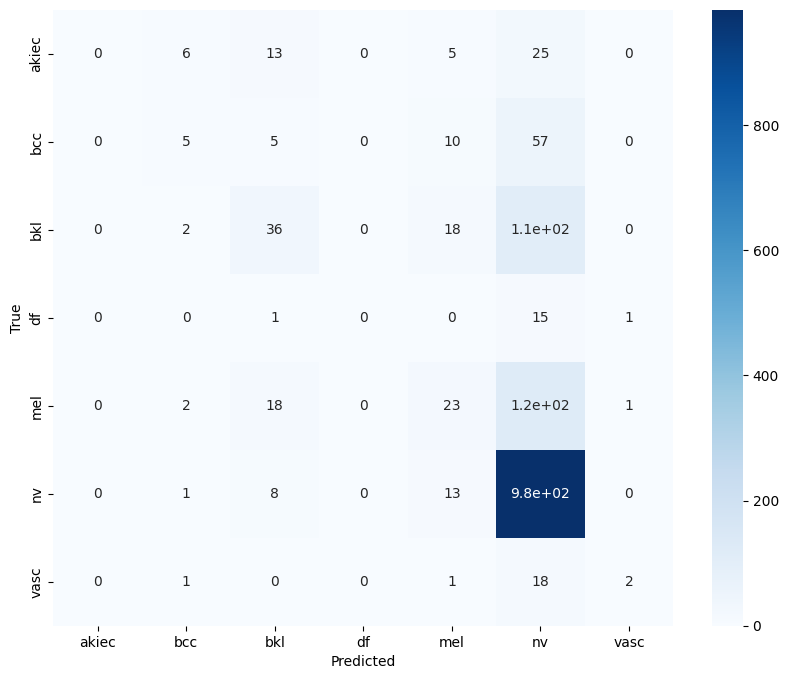

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
